In [1]:
from tensorflow.python.client import device_lib
import tensorflow as tf

from tensorflow import keras

import pandas as pd
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(pd.__version__)
plt.rcParams["figure.figsize"] = (20,3)

1.4.1


# Helper function

In [3]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='767541', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                    label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])



# loading the dataset

In [4]:
metr_df = pd.read_csv("./data/metr-la.csv", index_col=0)
road_distances_df = pd.read_csv("./data/sensor_graph/distances_la_2021.csv", names=["from","to","cost"])
graph_sensor = pd.read_csv("./data/sensor_graph/graph_sensor_ids.txt", header=None, sep=",")

In [5]:
# The number of timestamps that need to be taken into account before predicting the next
T = [12, 24, 72, 144, 288] 

# Forecasting horizons of 5 minutes, 15 minutes, 30 minutes and 1 hour
H = [1, 3, 6, 12]

CONV_WIDTH = 48
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

In [6]:
column_indices = {name: i for i, name in enumerate(metr_df.columns)}

n = len(metr_df)
train_metr_df = metr_df[:int(n * .7)]
val_metr_df = metr_df[int(n * .7):int(n * .9)]
test_metr_df = metr_df[int(n * .9):]

train_metr_mean = train_metr_df.mean()
train_metr_std = train_metr_df.std()

train_metr_df = (train_metr_df - train_metr_mean) / train_metr_std
val_metr_df = (val_metr_df - train_metr_mean) / train_metr_std
test_metr_df = (test_metr_df - train_metr_mean) / train_metr_std

In [7]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['767541'], train_df=train_metr_df, val_df=val_metr_df, test_df=test_metr_df)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['767541'], train_df=train_metr_df, val_df=val_metr_df, test_df=test_metr_df)


conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['767541'],
    train_df=train_metr_df, val_df=val_metr_df, test_df=test_metr_df)

wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['767541'],
    train_df=train_metr_df, val_df=val_metr_df, test_df=test_metr_df)

# Data analysis


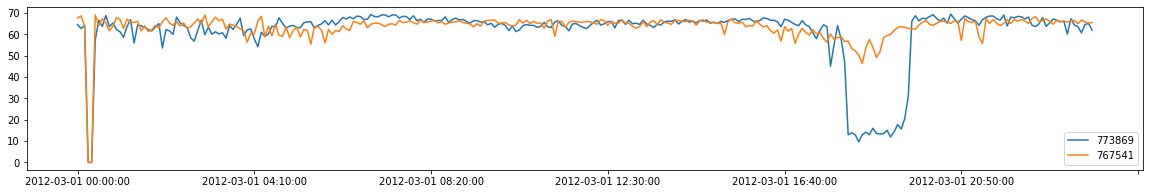

In [8]:
random_metr_data = metr_df[['773869', '767541']][:288]
random_metr_data.plot()
plt.show()

Inputs shape (batch, time, features): (32, 48, 207)
Labels shape (batch, time, features): (32, 1, 1)


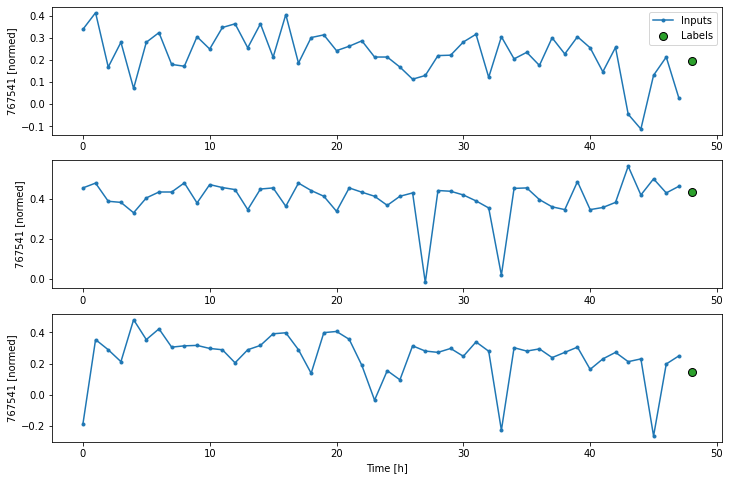

In [9]:
w2 = WindowGenerator(input_width=48, label_width=1, shift=1, label_columns=["767541"], train_df=train_metr_df, val_df=val_metr_df, test_df=test_metr_df)
w2

example_window = tf.stack([np.array(train_metr_df[:w2.total_window_size]),
                           np.array(train_metr_df[100:100+w2.total_window_size]),
                           np.array(train_metr_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

w2.plot()

for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

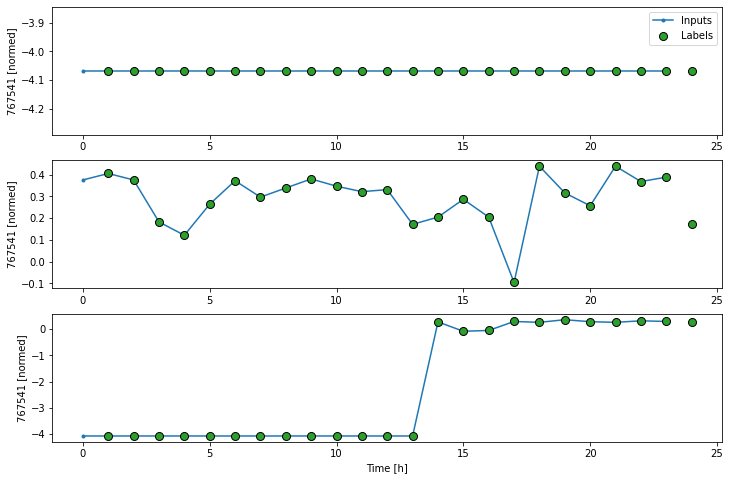

In [10]:
wide_window.plot()

In [ ]:
G = nx.read_weighted_edgelist("./data/sensor_graph/distances_la_2021.csv", delimiter=",", nodetype=str)
G.number_of_nodes()

nx.draw_kamada_kawai(G)

# Models

In [13]:
MAX_EPOCHS = 20

class MyModel(tf.keras.Model):
    def __init__(self):
        super().__init__()

    def compile_and_fit(self, model, window, patience=2):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

        model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

        history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
        return history

In [14]:
class Baseline(MyModel):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [15]:
class LinearModel(MyModel):
    def __init__(self):
        super().__init__()

    def call(self, window):
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(units=1)
        ])

        history = super().compile_and_fit(self.model, window)
        return self.model.evaluate(window.val), self.model.evaluate(window.test, verbose=0)

In [16]:
class DenseModel(MyModel):
    def __init__(self):
        super().__init__()

    def call(self, window):
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(units=64, activation='relu'),
            tf.keras.layers.Dense(units=64, activation='relu'),
            tf.keras.layers.Dense(units=1)
        ])

        history = super().compile_and_fit(self.model, window)
        return self.model.evaluate(window.val), self.model.evaluate(window.test, verbose=0)

In [17]:
class MultiDenseModel(MyModel):
    def __init__(self):
        super().__init__()

    def call(self, window):
        self.model = tf.keras.Sequential([
            # Shape: (time, features) => (time*features)
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=32, activation='relu'),
            tf.keras.layers.Dense(units=32, activation='relu'),
            tf.keras.layers.Dense(units=1),
            # Add back the time dimension.
            # Shape: (outputs) => (1, outputs)
            tf.keras.layers.Reshape([1, -1]),
        ])

        history = super().compile_and_fit(self.model, window)
        return self.model.evaluate(window.val), self.model.evaluate(window.test, verbose=0)

In [ ]:
class ConvModel(MyModel):
    def __init__(self):
        super().__init__()

    def call(self, window):
        self.model = tf.keras.Sequential([
            tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
            tf.keras.layers.Dense(units=32, activation='relu'),
            tf.keras.layers.Dense(units=1),
        ])

        history = super().compile_and_fit(self.model, window)
        return self.model.evaluate(window.val), self.model.evaluate(window.test, verbose=0)

In [18]:
class LstmModel(MyModel):
    def __init__(self):
        super().__init__()

    def call(self, window):
        self.model = tf.keras.Sequential([
            # Shape [batch, time, features] => [batch, time, lstm_units]
            tf.keras.layers.LSTM(32, return_sequences=True),
            # Shape => [batch, time, features]
            tf.keras.layers.Dense(units=1)
        ])

        history = super().compile_and_fit(self.model, window)
        return self.model.evaluate(window.val), self.model.evaluate(window.test, verbose=0)

# Evaluation

In [19]:
val_performance = {}
performance = {}

215/215 [==============================] - 1s 4ms/step - loss: 0.1451 - mean_absolute_error: 0.1455


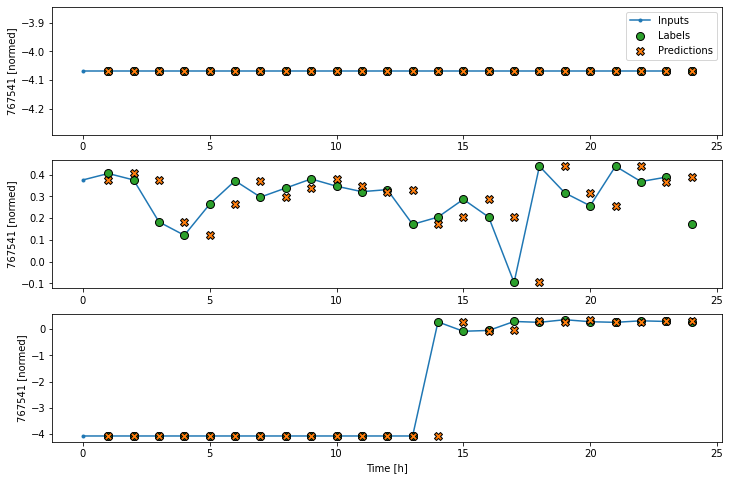

In [29]:
baseline = Baseline(label_index=column_indices['767541'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])


val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)
wide_window.plot(baseline)

Epoch 1/20
750/750 [==============================] - 3s 4ms/step - loss: 0.2682 - mean_absolute_error: 0.3306 - val_loss: 0.2172 - val_mean_absolute_error: 0.2868
Epoch 2/20
750/750 [==============================] - 3s 4ms/step - loss: 0.1726 - mean_absolute_error: 0.2251 - val_loss: 0.2006 - val_mean_absolute_error: 0.2399
Epoch 3/20
750/750 [==============================] - 2s 3ms/step - loss: 0.1578 - mean_absolute_error: 0.1995 - val_loss: 0.1708 - val_mean_absolute_error: 0.1999
Epoch 4/20
750/750 [==============================] - 2s 3ms/step - loss: 0.1516 - mean_absolute_error: 0.1862 - val_loss: 0.1546 - val_mean_absolute_error: 0.1963
Epoch 5/20
750/750 [==============================] - 2s 3ms/step - loss: 0.1483 - mean_absolute_error: 0.1778 - val_loss: 0.1664 - val_mean_absolute_error: 0.1885
Epoch 6/20
750/750 [==============================] - 2s 3ms/step - loss: 0.1454 - mean_absolute_error: 0.1721 - val_loss: 0.1465 - val_mean_absolute_error: 0.1783
Epoch 7/20
750/7

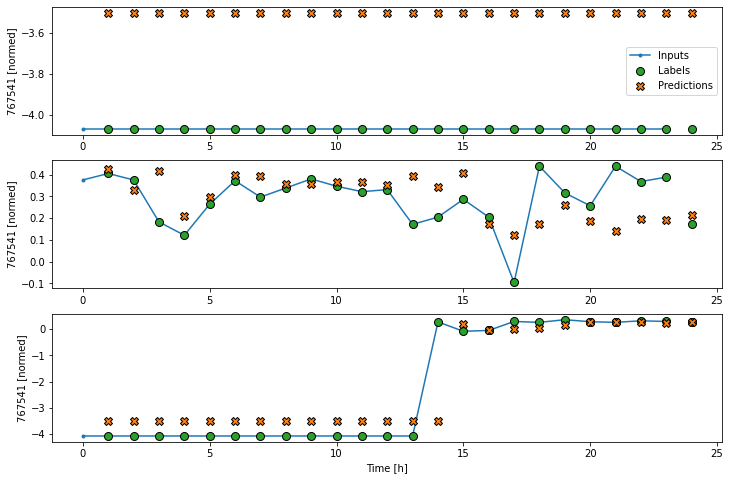

In [30]:
linearModel = LinearModel()
val_performance['Linear'], performance["Linear"] = linearModel(single_step_window)
wide_window.plot(linearModel.model)

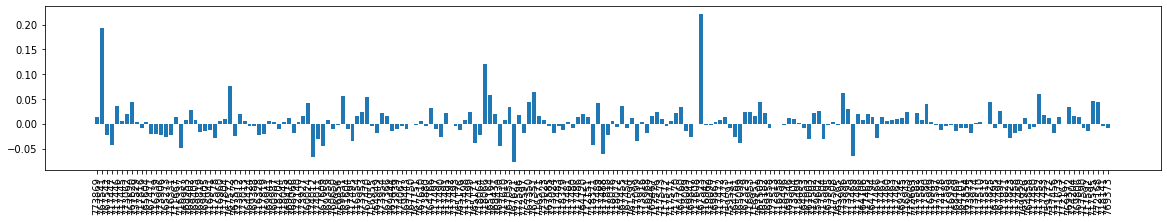

In [31]:
plt.bar(x = range(len(train_metr_df.columns)),
        height=linearModel.model.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_metr_df.columns)))
_ = axis.set_xticklabels(train_metr_df.columns, rotation=90)

Epoch 1/20
750/750 [==============================] - 4s 5ms/step - loss: 0.1586 - mean_absolute_error: 0.1876 - val_loss: 0.1409 - val_mean_absolute_error: 0.1676
Epoch 2/20
750/750 [==============================] - 3s 5ms/step - loss: 0.1385 - mean_absolute_error: 0.1599 - val_loss: 0.1454 - val_mean_absolute_error: 0.1699
Epoch 3/20
215/215 [==============================] - 1s 3ms/step - loss: 0.1445 - mean_absolute_error: 0.1533


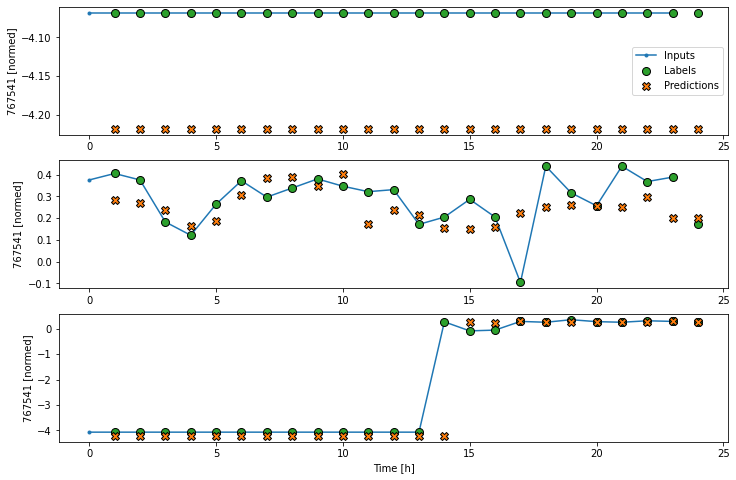

In [32]:
denseModel = DenseModel()
val_performance['Dense'], performance["Dense"] = denseModel(single_step_window)
wide_window.plot(denseModel.model)

Epoch 1/20
749/749 [==============================] - 4s 4ms/step - loss: 0.7306 - mean_absolute_error: 0.4453 - val_loss: 0.2894 - val_mean_absolute_error: 0.3306
Epoch 2/20
749/749 [==============================] - 3s 4ms/step - loss: 0.3193 - mean_absolute_error: 0.3355 - val_loss: 0.4013 - val_mean_absolute_error: 0.3680
Epoch 3/20
213/213 [==============================] - 1s 2ms/step - loss: 0.3809 - mean_absolute_error: 0.3562


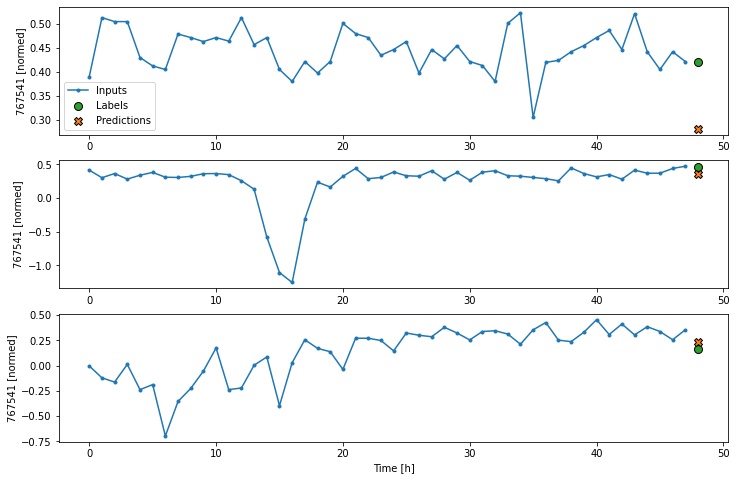

In [33]:
multiDenseModel = MultiDenseModel()
val_performance['MultiDense'], performance["MultiDense"] = multiDenseModel(conv_window)
conv_window.plot(multiDenseModel.model)

In [ ]:
# convModel = ConvModel()
# val_performance['Conv'], performance["Conv"] = convModel(conv_window)
# conv_window.plot(convModel.model)
# wide_conv_window.plot(convModel)

Epoch 1/20


Epoch 1/20
749/749 [==============================] - 8s 6ms/step - loss: 0.1267 - mean_absolute_error: 0.1590 - val_loss: 0.1427 - val_mean_absolute_error: 0.1696
Epoch 2/20
749/749 [==============================] - 4s 6ms/step - loss: 0.0958 - mean_absolute_error: 0.1324 - val_loss: 0.1502 - val_mean_absolute_error: 0.1790
Epoch 3/20
214/214 [==============================] - 1s 3ms/step - loss: 0.1660 - mean_absolute_error: 0.2033


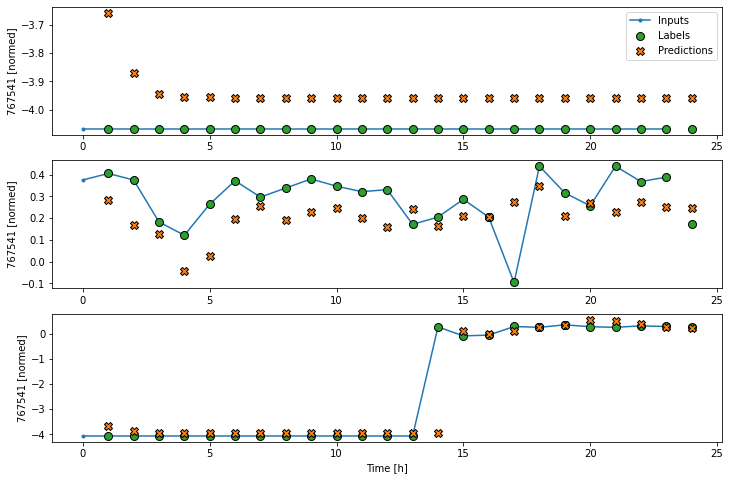

In [20]:
lstmModel = LstmModel()
val_performance['LSTM'], performance["LSTM"] = lstmModel(wide_window)
wide_window.plot(lstmModel.model)

{'LSTM': [0.16600605845451355, 0.20329812169075012], 'Baseline': [0.14509961009025574, 0.1455482691526413], 'Linear': [0.1493898183107376, 0.18547236919403076], 'Dense': [0.144477978348732, 0.15331394970417023], 'MultiDense': [0.3808925449848175, 0.35615280270576477]}


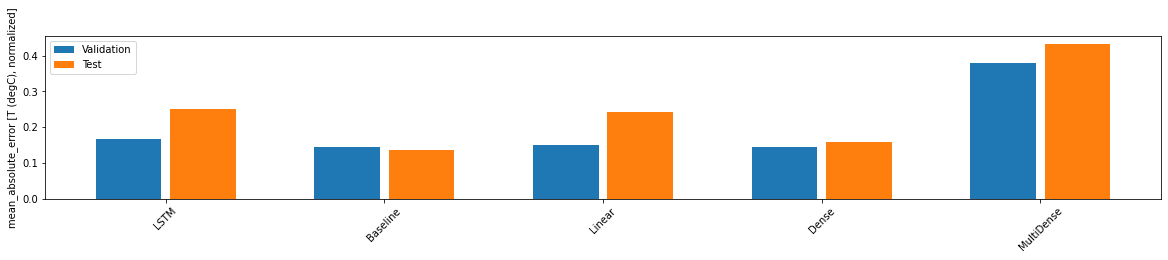

In [34]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
print(val_performance)
val_mae = [v[0] for v in val_performance.values()]
test_mae = [v[1] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
tf.test.is_built_with_cuda()
# tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 
# my output was => ['/device:CPU:0']
# good output must be => ['/device:CPU:0', '/device:GPU:0']

['/device:CPU:0', '/device:GPU:0']
